<a href="https://colab.research.google.com/github/ccarpenterg/LearningPyTorch1.x/blob/master/03_plotting_loss_and_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plotting Loss and Accuracy with PyTorch and Matplotlib

In [0]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import statistics

In [14]:
print('PyTorch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)

PyTorch version: 1.3.1
Torchvision version: 0.4.2


In [0]:
class BasicCNN(nn.Module):
    
    
    def __init__(self, num_channels, num_classes):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3*3*64, 64, bias=True)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, X):
        x = F.relu(self.conv1(X))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
cuda = torch.device('cuda')


# MNIST images are greyscale (1 channel) and there are 10 digits/classes 
model = BasicCNN(1, 10)
model.to(cuda)

BasicCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [17]:
dataset_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

train_set = MNIST('./mnist', train=True, download=True, transform=dataset_transform)
valid_set = MNIST('./mnist', train=False, download=True, transform=dataset_transform)

#checking the dimensions of the training and validation tensors
print(train_set.data.shape)
print(valid_set.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [0]:
train_loader = DataLoader(train_set, batch_size=128, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [0]:
def train(model, loss_fn, optimizer):
    
    model.train()
    train_batch_losses = []
    
    for batch, labels in train_loader:
        
        batch = batch.to(cuda)
        labels = labels.to(cuda)
        
        optimizer.zero_grad()
        y_pred = model(batch)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        train_batch_losses.append(float(loss))
        mean_loss = statistics.mean(train_batch_losses)
        
    return mean_loss

In [0]:
def validate(model, loss_fn, optimizer):
    
    model.eval()
    predictions = []
    
    with torch.no_grad():
        
        validation_batch_losses = []
        
        for batch, labels in valid_loader:
            
            batch = batch.to(cuda)
            labels = labels.to(cuda)
            
            labels_pred = model(batch)
            loss = loss_fn(labels_pred, labels)
            
            validation_batch_losses.append(float(loss))
            
            mean_loss = statistics.mean(validation_batch_losses)
            
        return mean_loss

In [0]:
def accuracy(model, loader):
    
    correct = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, labels in loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)
            
            output = model(batch)
            
            _, predicted = torch.max(output.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            return (correct / total) * 100

In [0]:
def training_stats(train_loss, train_accuracy, val_loss, val_accuracy):
    print(('training loss: {:.3f} '
           'training accuracy: {:.2f}% || '
           'val. loss: {:.3f} '
           'val. accuracy: {:.2f}%').format(train_loss, train_accuracy,
                                            val_loss, val_accuracy))

In [24]:
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 20

train_losses = []
valid_losses = []

train_accuracies = []
valid_accuracies = []

for epoch in range(1, 1 + EPOCHS):
    
    train_loss = train(model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracy = accuracy(model, train_loader)
    train_accuracies.append(train_accuracy)
    
    valid_loss = validate(model, loss_fn, optimizer)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy(model, valid_loader)
    valid_accuracies.append(valid_accuracy)
    
    print('Epoch {}/{}'.format(epoch, EPOCHS))

    training_stats(train_loss, train_accuracy, valid_loss, valid_accuracy)

Epoch 1/20
training loss: 0.263 training accuracy: 100.00% || val. loss: 0.059 val. accuracy: 97.27%
Epoch 2/20
training loss: 0.061 training accuracy: 100.00% || val. loss: 0.044 val. accuracy: 98.44%
Epoch 3/20
training loss: 0.048 training accuracy: 99.22% || val. loss: 0.050 val. accuracy: 99.02%
Epoch 4/20
training loss: 0.039 training accuracy: 96.09% || val. loss: 0.078 val. accuracy: 98.05%
Epoch 5/20
training loss: 0.034 training accuracy: 99.22% || val. loss: 0.035 val. accuracy: 98.24%
Epoch 6/20
training loss: 0.031 training accuracy: 99.22% || val. loss: 0.043 val. accuracy: 98.83%
Epoch 7/20
training loss: 0.028 training accuracy: 100.00% || val. loss: 0.048 val. accuracy: 99.02%
Epoch 8/20
training loss: 0.025 training accuracy: 99.22% || val. loss: 0.046 val. accuracy: 98.83%
Epoch 9/20
training loss: 0.024 training accuracy: 100.00% || val. loss: 0.057 val. accuracy: 98.44%
Epoch 10/20
training loss: 0.026 training accuracy: 100.00% || val. loss: 0.051 val. accuracy: 9

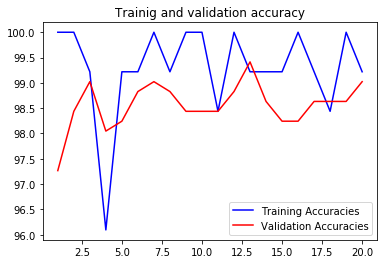

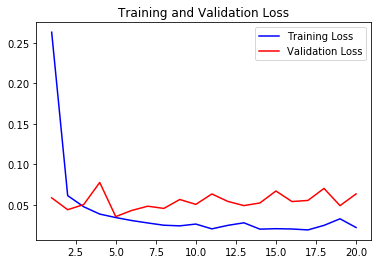

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_accuracies, 'b', label='Training Accuracies')
plt.plot(epochs, valid_accuracies, 'r', label='Validation Accuracies')
plt.title('Trainig and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, valid_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()